<a href="https://colab.research.google.com/github/franklinscudder/HeraldNet/blob/main/HeraldNet_Out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LAST RUN: Batch 33 of 33,  Epoch 696 of 1000
torch.Size([33, 10, 10])
tensor(0.2206)
tensor([0.1792, 0.2105, 0.1497, 0.2268, 0.2047, 0.2113, 0.2696, 0.0708, 0.2803,
        0.4029])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


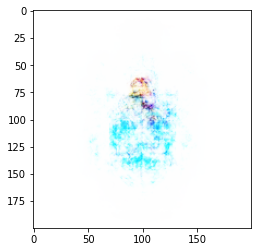

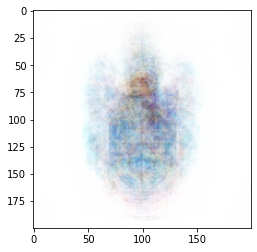

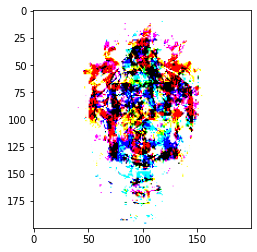

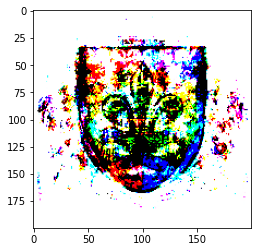

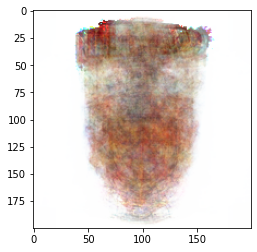

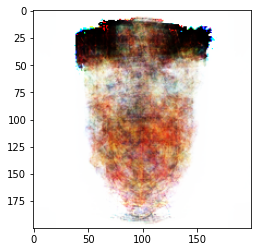

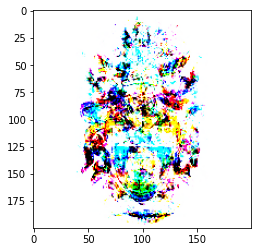

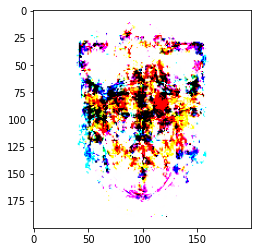

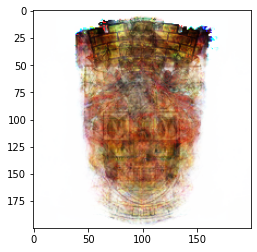

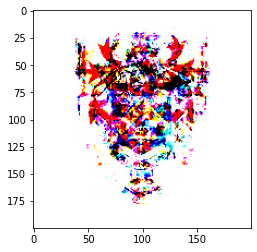

In [ ]:
PC1 = 4.9 #@param {type:"slider", min:-10, max:10, step:0.1}
PC2 = -0.7 #@param {type:"slider", min:-10, max:10, step:0.1}
PC3 = -0.7 #@param {type:"slider", min:-10, max:10, step:0.1}
PC4 = 1.1 #@param {type:"slider", min:-10, max:10, step:0.1}
PC5 = -2 #@param {type:"slider", min:-10, max:10, step:0.1}
PC6 = 1.1 #@param {type:"slider", min:-10, max:10, step:0.1}
PC7 = 1 #@param {type:"slider", min:-10, max:10, step:0.1}
PC8 = -2.3 #@param {type:"slider", min:-10, max:10, step:0.1}
PC9 = -0.6 #@param {type:"slider", min:-10, max:10, step:0.1}
PC10 = -0.2 #@param {type:"slider", min:-10, max:10, step:0.1}


from torch import Tensor, tensor, mean, zeros, stack, device, empty, FloatTensor, pca_lowrank, matmul, inverse, no_grad
from torch import save as torchSave
from torch import load as torchLoad
from torch import mean as torchMean
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL
from PIL import ImageOps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
from IPython.display import clear_output
import pickle
import time

#PCs = tensor([PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10])/5
#PCs = tensor([random.random() for i in range(10)])


class HeraldNet(nn.Module):
    def __init__(self, nInputs, latentSize, indexInput=True):
        super(HeraldNet, self).__init__()
        self.latentSize = latentSize

        if indexInput:
            self.l1 = nn.Linear(nInputs, self.latentSize)
        
        else:
            self.c1 = nn.Conv2d(3, int(self.latentSize/2), 20)
            self.p1 = nn.MaxPool2d(20)
            self.c2 = nn.Conv2d(int(self.latentSize/2), self.latentSize, 2, padding=1)
            self.p2 = nn.MaxPool2d(10)
        
        self.indexInput = indexInput
        self.l2 = nn.Linear(self.latentSize, 200*3)
        self.l3 = nn.Linear(200*3,1000*3)
        self.l4 = nn.Linear(1000*3, 40000*3)  # 200x200x3
    
    def forward(self, inp):
        
        BATCH_SIZE = inp.shape[0]

        #if self.indexInput:
        #    i = F.sigmoid(self.l1(inp))
        
        #else:
        #    i = self.c1(inp)
        #    i = self.p1(i)
        #    i = self.c2(i)
        #    i = self.p2(i)
        #    i = i.reshape(BATCH_SIZE, self.latentSize)

        

        #latentSamples.append(i.data)
        
        i = F.relu(self.l2(inp))
        i = F.relu(self.l3(i))
        i = F.sigmoid(self.l4(i))
        i = i.reshape(BATCH_SIZE,3,40000)

        return i

def getListOfFiles(dirName): 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            if "Arms" in fullPath:  
                allFiles.append(r'{}'.format(fullPath))

    return allFiles

def loadImageTensor(path):
    img = PIL.Image.open(path)
    w, h = img.size
    bg = PIL.Image.new('RGB', (400, 400), color = 'white')
    bg.paste(img, (int(200-(w/2)), int(200-(h/2))))
    img = bg
    img.thumbnail((200,200), PIL.Image.ANTIALIAS)
    data = np.array(list(img.getdata()))
    data = data/255
    t = tensor(data.astype(float))
    img.close()
    return t.permute(1,0)

def constructImage(data):
    #D = np.array([(data[i], data[i+1], data[i+2]) for i in range(0, len(data), 3)])
    Di = np.zeros((200,200,3))

    for x in range(200):
        for y in range(200):
            Di[x,y,:] = data[:, y + 200*x]

    return Di


#####################################

txt = open("/content/drive/My Drive/HeraldNet/txt2.pkl","rb")
stri = pickle.load(txt)
print("LAST RUN: " + stri)

allFiles = getListOfFiles('/content/drive/My Drive/HeraldNet/images')
#random.shuffle(allFiles)
#print("All Files: ", len(allFiles) , allFiles)

N = 337 #len(allFiles)

BATCH_SIZE = 10
#N_EPOCHS = 1000
INDEX_INPUT = True
LATENT_SIZE = 10
#EPOCH_SIZE = int(len(allFiles)/float(BATCH_SIZE))

dev = device('cpu')
net = HeraldNet(N, LATENT_SIZE, indexInput=INDEX_INPUT)#.cuda(dev)
loss = nn.MSELoss()
opt = optim.Adam(net.parameters(), lr=1e-2)

losses = []

t0 = time.time()


net.load_state_dict(torchLoad("/content/drive/My Drive/HeraldNet/net2.pt"))
net.eval()

ls = open("/content/drive/My Drive/HeraldNet/ls2.pkl","rb")
latentSamples = pickle.load(ls)
latentSamples = stack(latentSamples)
print(latentSamples.shape)
latentSamples = latentSamples.view(latentSamples.shape[0] * latentSamples.shape[1],-1)
print(mean(latentSamples.abs()))

ls.close()

U, S, V = pca_lowrank(latentSamples.unsqueeze(0),q=10)
LCMean = torchMean(latentSamples,dim=0)
print(LCMean)

for i in range(10):
    PCs = tensor([random.gauss(0,1) for j in range(10)])
    LCs = matmul(PCs, inverse(V[:,:10])) + LCMean

    with no_grad():
        out = net(LCs.data).squeeze()
        plt.imshow(constructImage(out))
        plt.show()








